Men's Shoe Prices
The goal of this kernel is to complete the task associated with the dataset. The specific goals include:

    - What is the average price of each distinct brand listed?
    - Which brands have the highest prices?
    - Which ones have the widest distribution of prices?
    - Is there a typical price distribution (e.g., normal) across brands or within specific brands?
    - Correlate specific product features with changes in price.
One thing to note before we begin... This dataset includes a lot of information on products that aren't actually shoes! Items such as watches and other accessories seem to have been mistakenly included during the original data gathering process (likely due to mislabeled categories). Fully correcting for this would require a decent amount of manual work / advanced regex and NLP and is outside the scope of this kernel. As a result, please interpret the final outputs with a grain of salt and as not fully reflective of reality beyond this dataset. That being said, the general code and methodologies used within should still be a useful learning experience!

Let's dive in!

# Imports & Settings

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [2]:
df = pd.read_csv("train.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (39,45) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Data Cleaning / Preprocessing¶


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19387 entries, 0 to 19386
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   19387 non-null  object 
 1   asins                2571 non-null   object 
 2   brand                19129 non-null  object 
 3   categories           19387 non-null  object 
 4   colors               11048 non-null  object 
 5   count                0 non-null      float64
 6   dateadded            19387 non-null  object 
 7   dateupdated          19387 non-null  object 
 8   descriptions         9904 non-null   object 
 9   dimension            2991 non-null   object 
 10  ean                  9999 non-null   float64
 11  features             13997 non-null  object 
 12  flavors              0 non-null      float64
 13  imageurls            18342 non-null  object 
 14  isbn                 0 non-null      float64
 15  keys                 19387 non-null 

In [4]:
sum_nans = df.isna().sum() / df.shape[0]
sum_nans

id                     0.000000
asins                  0.867385
brand                  0.013308
categories             0.000000
colors                 0.430134
count                  1.000000
dateadded              0.000000
dateupdated            0.000000
descriptions           0.489142
dimension              0.845721
ean                    0.484242
features               0.278021
flavors                1.000000
imageurls              0.053902
isbn                   1.000000
keys                   0.000000
manufacturer           0.654459
manufacturernumber     0.218703
merchants              0.275803
name                   0.000000
prices_amountmin       0.000516
prices_amountmax       0.000000
prices_availability    0.989839
prices_color           0.960902
prices_condition       0.348997
prices_count           0.996338
prices_currency        0.003920
prices_dateadded       0.000774
prices_dateseen        0.001290
prices_flavor          0.996080
prices_issale          0.003404
prices_m

# Dropping Columns
The data is fairly messy as it currently stands. There are lots of missing values (some columns are even entirely missing) and there are various data types that need corrected. Given the limited number of questions being answered for this task, a good chunk of the available data is irrelevant. Right off the bat, let's eliminate any columns that are missing 80% or more of their values. This will help reduce the size of the data we're working with and make further cleaning processes a bit easier.

In [5]:
cols_to_drop = [col for col in df.isna().sum() / df.shape[0] >= 0.8]

In [6]:
sum_nans.index[cols_to_drop]

Index(['asins', 'count', 'dimension', 'flavors', 'isbn', 'prices_availability',
       'prices_color', 'prices_count', 'prices_flavor', 'prices_returnpolicy',
       'prices_size', 'prices_source', 'prices_warranty', 'quantities',
       'reviews', 'vin', 'websiteids', 'weight'],
      dtype='object')

In [7]:
df.drop(sum_nans.index[cols_to_drop],axis=1, inplace= True)

In [8]:
df.columns

Index(['id', 'brand', 'categories', 'colors', 'dateadded', 'dateupdated',
       'descriptions', 'ean', 'features', 'imageurls', 'keys', 'manufacturer',
       'manufacturernumber', 'merchants', 'name', 'prices_amountmin',
       'prices_amountmax', 'prices_condition', 'prices_currency',
       'prices_dateadded', 'prices_dateseen', 'prices_issale',
       'prices_merchant', 'prices_offer', 'prices_shipping',
       'prices_sourceurls', 'sizes', 'skus', 'sourceurls', 'upc'],
      dtype='object')

## Starting to get somewhere, but there's still more columns to drop:



In [9]:
df.drop(columns=['id', 'dateadded', 'dateupdated', 'descriptions', 'ean', 
                 'features', 'imageurls', 'keys', 'manufacturer',
                 'manufacturernumber', 'merchants', 'prices_condition',
                 'prices_dateadded', 'prices_dateseen', 'prices_issale',
                 'prices_merchant', 'prices_offer', 'prices_shipping',
                 'prices_sourceurls', 'sizes', 'skus', 'sourceurls', 'upc'],
       inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19387 entries, 0 to 19386
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   brand             19129 non-null  object
 1   categories        19387 non-null  object
 2   colors            11048 non-null  object
 3   name              19387 non-null  object
 4   prices_amountmin  19377 non-null  object
 5   prices_amountmax  19387 non-null  object
 6   prices_currency   19311 non-null  object
dtypes: object(7)
memory usage: 1.0+ MB


In [10]:
df.head()

,brand,categories,colors,name,prices_amountmin,prices_amountmax,prices_currency
0,Josmo,"Clothing,Shoes,Men's Shoes,All Men's Shoes",NaN,"Josmo 8190 Plain Infant Walking Shoes, Navy - ...",39.89,39.89,USD
1,Josmo,"Clothing,Shoes,Men's Shoes,All Men's Shoes",NaN,"Josmo 8190 Plain Infant Walking Shoes, Navy - ...",51.99,51.99,USD
2,SERVUS BY HONEYWELL,"All Men's Shoes,Shoes,Men's Shoes,Clothing",NaN,Servus By Honeywell Shoe Studs Zsr101blmlg,40.02,40.02,USD
3,SERVUS BY HONEYWELL,"All Men's Shoes,Shoes,Men's Shoes,Clothing",NaN,Servus By Honeywell Shoe Studs Zsr101blmlg,50.31,50.31,USD
4,SERVUS BY HONEYWELL,"All Men's Shoes,Shoes,Men's Shoes,Clothing",NaN,Servus By Honeywell Shoe Studs Zsr101blmlg,46.26,46.26,USD


# Adjusting Data Types
## Some finishing touches by adjusting the data types:



In [11]:
df.prices_amountmin = pd.to_numeric(df.prices_amountmin,errors='coerce', downcast='float')
df.prices_amountmax = pd.to_numeric(df.prices_amountmax,errors='coerce', downcast='float')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19387 entries, 0 to 19386
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   brand             19129 non-null  object 
 1   categories        19387 non-null  object 
 2   colors            11048 non-null  object 
 3   name              19387 non-null  object 
 4   prices_amountmin  19294 non-null  float32
 5   prices_amountmax  19350 non-null  float32
 6   prices_currency   19311 non-null  object 
dtypes: float32(2), object(5)
memory usage: 908.9+ KB


In [13]:
df.head()

,brand,categories,colors,name,prices_amountmin,prices_amountmax,prices_currency
0,Josmo,"Clothing,Shoes,Men's Shoes,All Men's Shoes",NaN,"Josmo 8190 Plain Infant Walking Shoes, Navy - ...",39.889999,39.889999,USD
1,Josmo,"Clothing,Shoes,Men's Shoes,All Men's Shoes",NaN,"Josmo 8190 Plain Infant Walking Shoes, Navy - ...",51.990002,51.990002,USD
2,SERVUS BY HONEYWELL,"All Men's Shoes,Shoes,Men's Shoes,Clothing",NaN,Servus By Honeywell Shoe Studs Zsr101blmlg,40.020000,40.020000,USD
3,SERVUS BY HONEYWELL,"All Men's Shoes,Shoes,Men's Shoes,Clothing",NaN,Servus By Honeywell Shoe Studs Zsr101blmlg,50.310001,50.310001,USD
4,SERVUS BY HONEYWELL,"All Men's Shoes,Shoes,Men's Shoes,Clothing",NaN,Servus By Honeywell Shoe Studs Zsr101blmlg,46.259998,46.259998,USD


## Much better!


### Cleaning Final Dataframe
Prices
The two columns for price (prices_amountmin and prices_amountmax) caught my eye since the first five rows in the dataframe have the same value for both. To investigate this further, let's check what percentage of the rows have the same value in both columns.

In [14]:
(df.prices_amountmax == df.prices_amountmin).sum() / df.shape[0]

0.9614690256357353

Over 96%! As a result, I'm okay with combining the two columns into a single column called price by taking the average.



In [15]:
df['price'] = np.mean([df.prices_amountmax , df.prices_amountmin], axis=0)
df_cleaned = df.drop(['prices_amountmax' , 'prices_amountmin'],axis=1)

In [16]:
df_cleaned

,brand,categories,colors,name,prices_currency,price
0,Josmo,"Clothing,Shoes,Men's Shoes,All Men's Shoes",NaN,"Josmo 8190 Plain Infant Walking Shoes, Navy - ...",USD,39.889999
1,Josmo,"Clothing,Shoes,Men's Shoes,All Men's Shoes",NaN,"Josmo 8190 Plain Infant Walking Shoes, Navy - ...",USD,51.990002
2,SERVUS BY HONEYWELL,"All Men's Shoes,Shoes,Men's Shoes,Clothing",NaN,Servus By Honeywell Shoe Studs Zsr101blmlg,USD,40.020000
3,SERVUS BY HONEYWELL,"All Men's Shoes,Shoes,Men's Shoes,Clothing",NaN,Servus By Honeywell Shoe Studs Zsr101blmlg,USD,50.310001
4,SERVUS BY HONEYWELL,"All Men's Shoes,Shoes,Men's Shoes,Clothing",NaN,Servus By Honeywell Shoe Studs Zsr101blmlg,USD,46.259998
...,...,...,...,...,...,...
19382,"Xray, XRay","Clothing, Shoes & Accessories,Men's Shoes,Boots",Black,New Xray Hester Men's Lace Up Boots - Black - ...,USD,29.950001
19383,Fila,"Clothing,Shoes,Men's Shoes,All Men's Shoes",NaN,Fila Men's Original Tennis Navy/white/gold Fas...,USD,64.949997
19384,Seek Optics,"Women's Sunglasses,Sunglasses,Bags & Accessori...",NaN,Seek Optics New Seek Polarized Replacement Len...,USD,32.480000
19385,Seek Optics,"Women's Sunglasses,Sunglasses,Bags & Accessori...",NaN,Seek Optics New Seek Polarized Replacement Len...,USD,31.480000


Next, let's check the value counts for the prices_currency column.



In [17]:
df_cleaned.prices_currency.value_counts()

USD                                                   18524
AUD                                                     338
CAD                                                     303
EUR                                                     107
GBP                                                      22
new                                                       3
PalmBeach Jewelry - Walmart.com                           3
New with box                                              3
UnbeatableSale.com, Inc. - Walmart.com                    3
Wholesale Costume and Party Supplies - Walmart.com        2
Shoes.com                                                 1
SHOEBACCA LTD. - Walmart.com                              1
New without tags                                          1
Name: prices_currency, dtype: int64

It appears that some data was incorrectly placed in the prices_currency column in the original dataset. The overwhelming majority is priced in USD though. We could either work on converting the other currencies to USD for accurate comparisons, or simply drop those rows. For the sake of simplicity in this kernel, let's drop the rows.

In [18]:
df_cleaned = df_cleaned[df_cleaned.prices_currency == 'USD']

In [19]:
df_cleaned.prices_currency.value_counts()

USD    18524
Name: prices_currency, dtype: int64

### Missing Values


In [20]:
df_cleaned.isna().sum()

brand                17
categories            0
colors             7984
name                  0
prices_currency       0
price                 0
dtype: int64

#### *The missing values in the color column are fine for now but the 17 missing values for the brand column need handled.*

In [21]:
df_cleaned.dropna(subset=["brand"],axis=0,inplace=True)

<ipython-input-21-74686a94748a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.dropna(subset=["brand"],axis=0,inplace=True)


In [22]:
df_cleaned.isna().sum()

brand                 0
categories            0
colors             7981
name                  0
prices_currency       0
price                 0
dtype: int64

### Standardizing Brands
Finally, let's change all of the brand names to lowercase. This is to help prevent any variations in capitalization from being classified as different brands. While a more serious method of cleaning the brand names would need to be employed in any sort of production code, this will suffice for now.

In [23]:
df_cleaned.brand = df_cleaned.brand.apply( lambda x:  x.lower())
df_cleaned.brand.head(10)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0                  josmo
1                  josmo
2    servus by honeywell
3    servus by honeywell
4    servus by honeywell
5    servus by honeywell
6    servus by honeywell
7    servus by honeywell
8    servus by honeywell
9    servus by honeywell
Name: brand, dtype: object

# Answering the Questions
What is the average price of each distinct brand listed?
To begin answering this questions, let's first take a look at how many unique brands are in the data

In [24]:
df_cleaned.brand.nunique()

1735

Wow! That's way too many to effectively visualize. Let's limit the brands we look at to only those with more than 50 rows of data. This will help eliminate random, unheard of brands with only a couple entries as well as entries which aren't actually

In [25]:
brands_above_50 = df_cleaned.brand.value_counts()[df_cleaned.brand.value_counts() > 50]
brands_above_50

nike                           1778
ralph lauren                    699
puma                            610
vans                            386
new balance                     371
reebok                          277
adidas                          258
jordan                          200
superior glove works            182
fossa apparel                   174
fuse lenses                     174
skechers                        165
converse                        153
dickies                         144
unbranded                       134
unique bargains                 127
berne apparel                   126
crocs                           120
toms                            115
asics                           114
kinco                           110
national safety apparel inc     107
under armour                    105
gameday boots                   103
stacy adams                      98
scully                           96
georgia boot                     94
polo ralph lauren           

In [26]:
df_brands = df_cleaned[df_cleaned.brand.isin(brands_above_50.index)].groupby("brand").price.mean()
df_brands.sort_values(ascending=False,inplace=True)
df_brands

brand
ralph lauren                   509.997437
invicta                        414.075256
casio                          384.682953
fizik                          296.242737
gameday boots                  235.530197
scully                         230.631042
national safety apparel inc    209.457199
maui jim                       184.454620
justin boots                   172.847672
georgia boot                   163.283829
ray-ban                        160.380173
superior glove works           138.317200
rocky                          133.877228
kinco                          130.445633
cole haan                      126.020729
bgood                          123.624069
jordan                         117.739273
carrera                        112.396278
caterpillar                    109.932961
adidas                         109.491005
kenneth cole ny                106.038353
dr. martens                    104.921783
nike                            97.865257
asics                       

Text(0, 0.5, 'Brand')

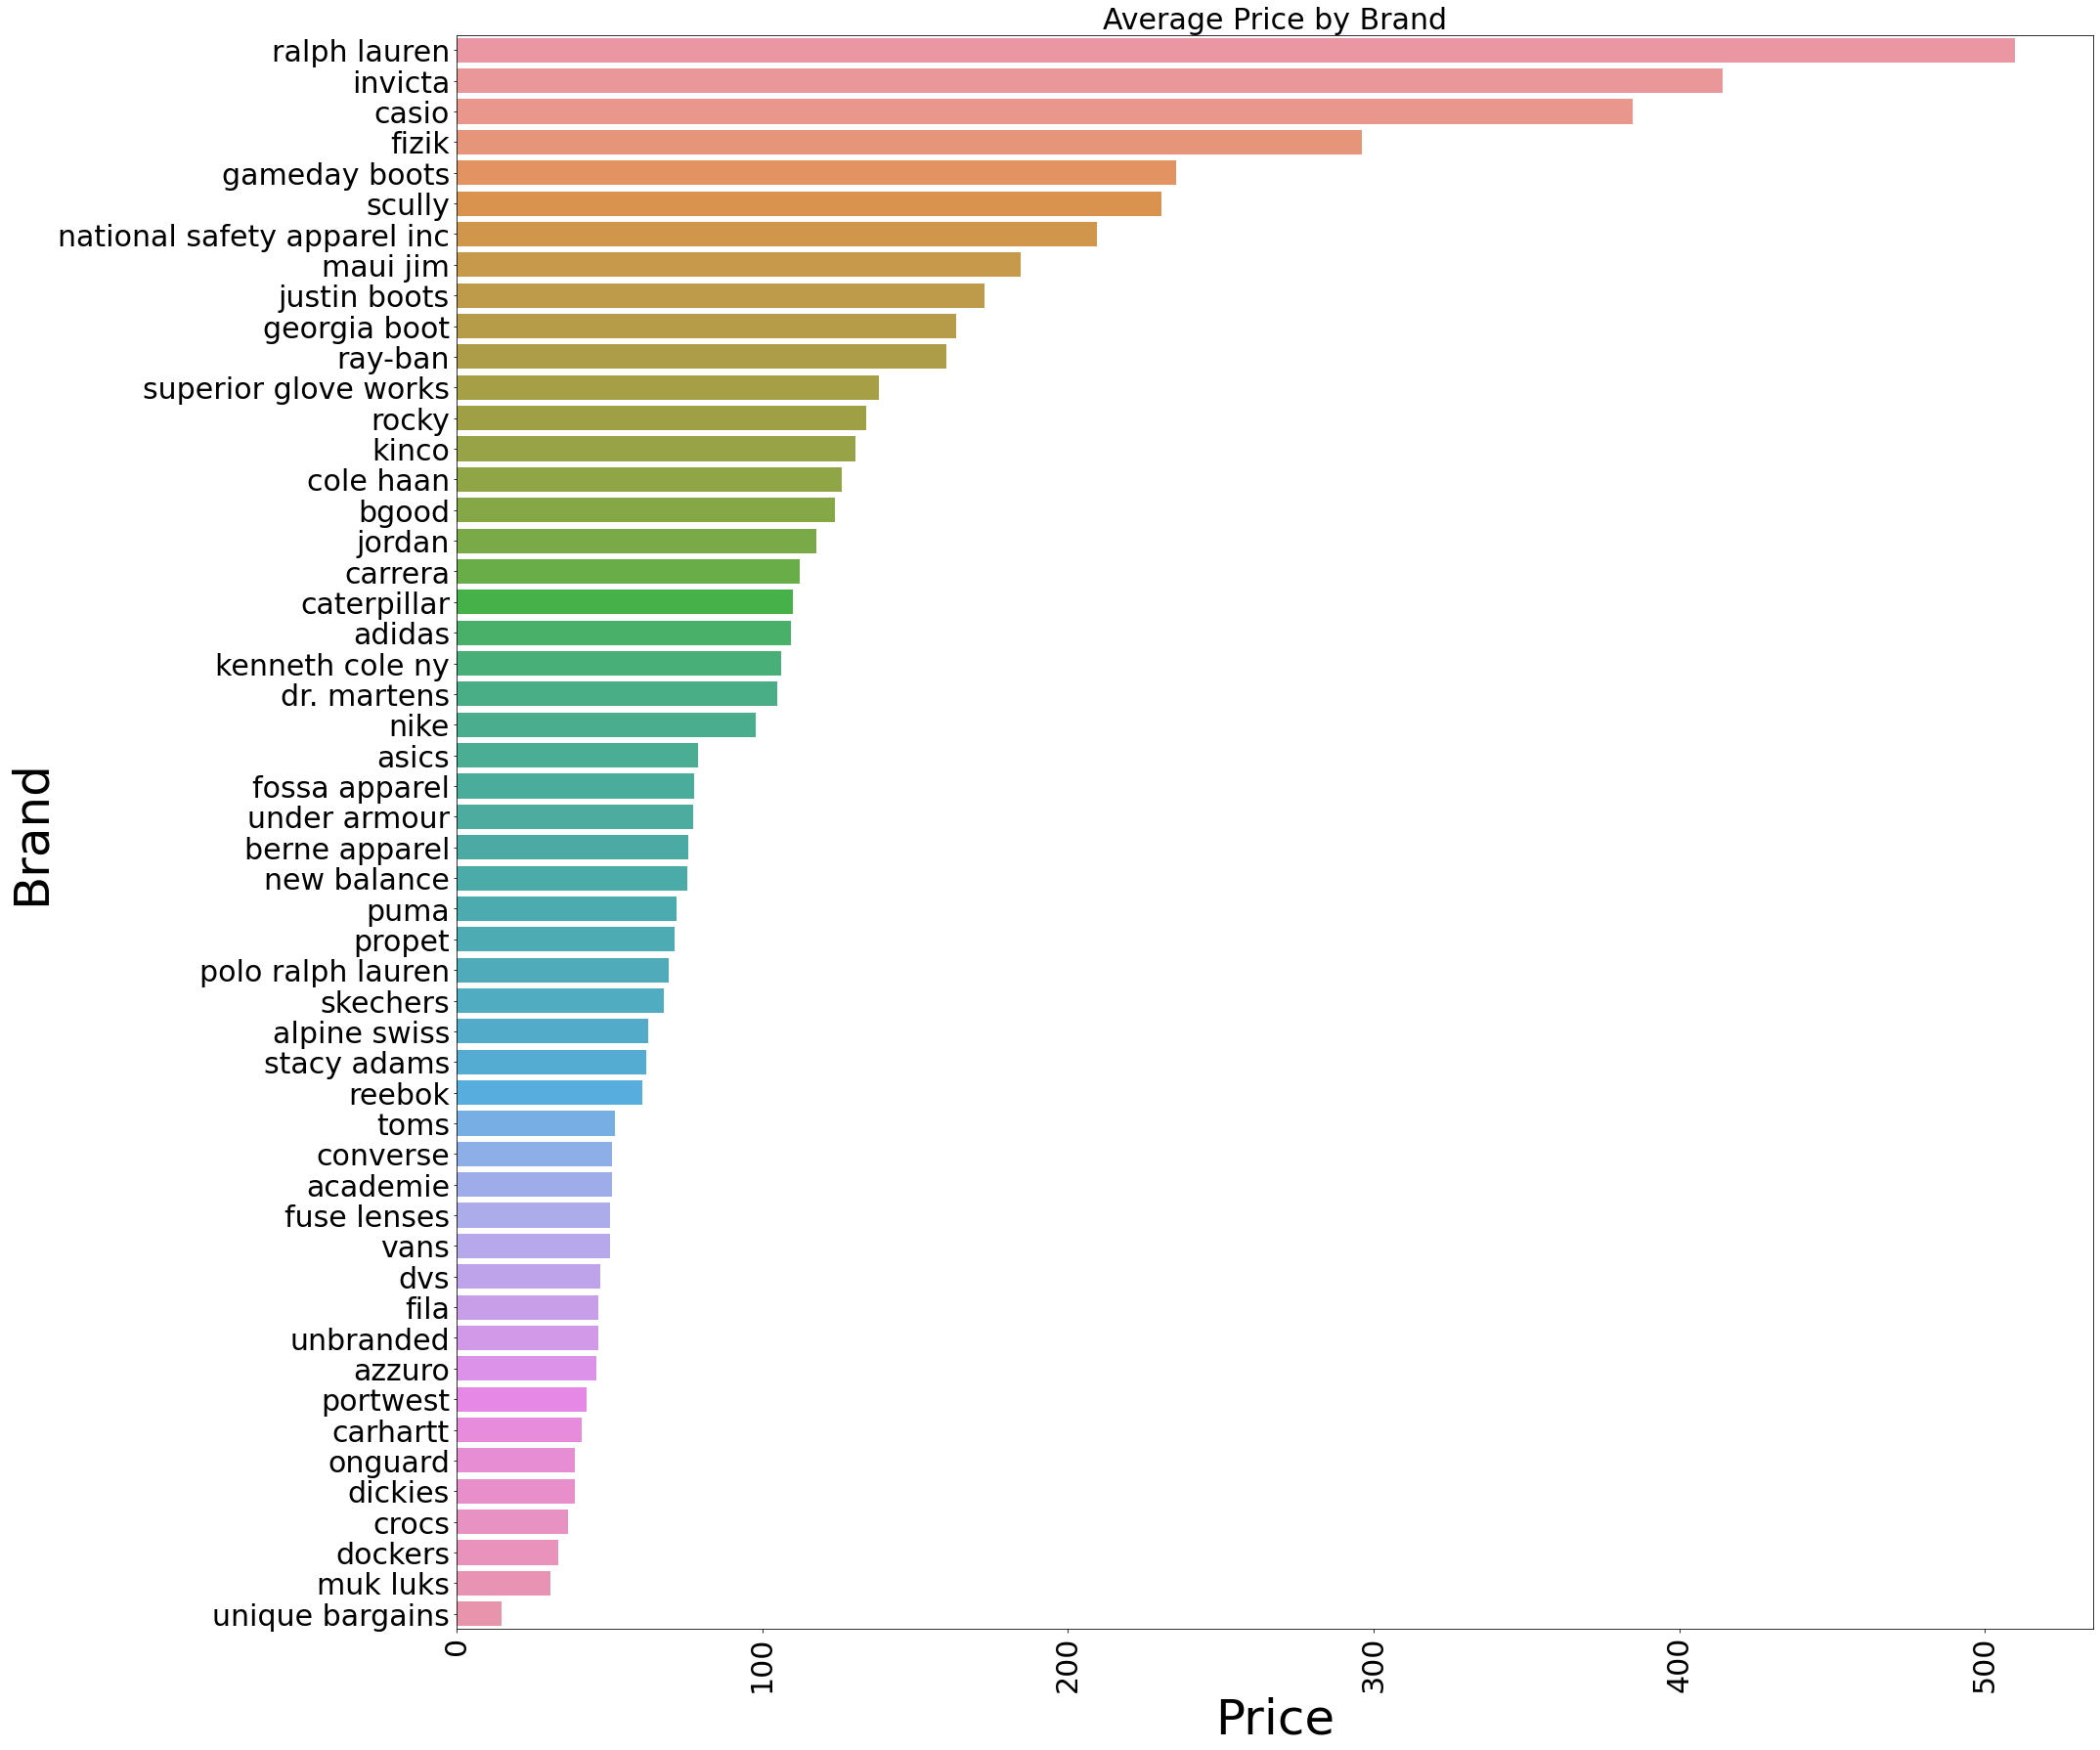

In [27]:
fig = plt.figure(figsize=(30, 30))
sns.barplot(y=df_brands.index,x=df_brands)
plt.xticks(fontsize=30, rotation=90)
plt.yticks(fontsize=30)
plt.title('Average Price by Brand',fontsize=30)
plt.xlabel('Price',fontsize=50)
plt.ylabel('Brand',fontsize=50)

### Which brands have the highest prices?
             


In [28]:
df_max_prices = df_cleaned[df_cleaned.brand.isin(brands_above_50.index)].sort_values(by= "price",ascending=False)
df_max_prices.drop_duplicates("brand",inplace=True)
df_max_prices[['brand', 'name', 'price']].head(10)

,brand,name,price
1452,adidas,Yeezy Boost 350 Turtle Doves Kanye West 2015 P...,2799.949951
15719,ralph lauren,Crocodile Barnet Espadrille,2100.000000
17345,national safety apparel inc,National Safety Apparel Inc National Safety Ap...,2083.030029
13901,invicta,Invicta Men's 6105 Venom Reserve Chronograph G...,1995.000000
4388,superior glove works,Superior Glove Works Superior Spgrk Contender ...,1647.310059
554,casio,Casio G-shock Mt-g Tough Solar Mens Watch Mtg...,1400.000000
11249,nike,Nike Air Jordan Xii 12 Rare Wings Men's Shoes ...,1225.000000
4020,unbranded,"""Men's Black Faux Leather Business Briefcase M...",1134.989990
6977,puma,Jersey Chivas 110 A��os Conmemorativa 1906 Pie...,1100.000000
17131,jordan,"""Jordan Mens Air Jordan 11 Retro Prem ""grey Su...",749.000000


Text(0, 0.5, 'Brand')

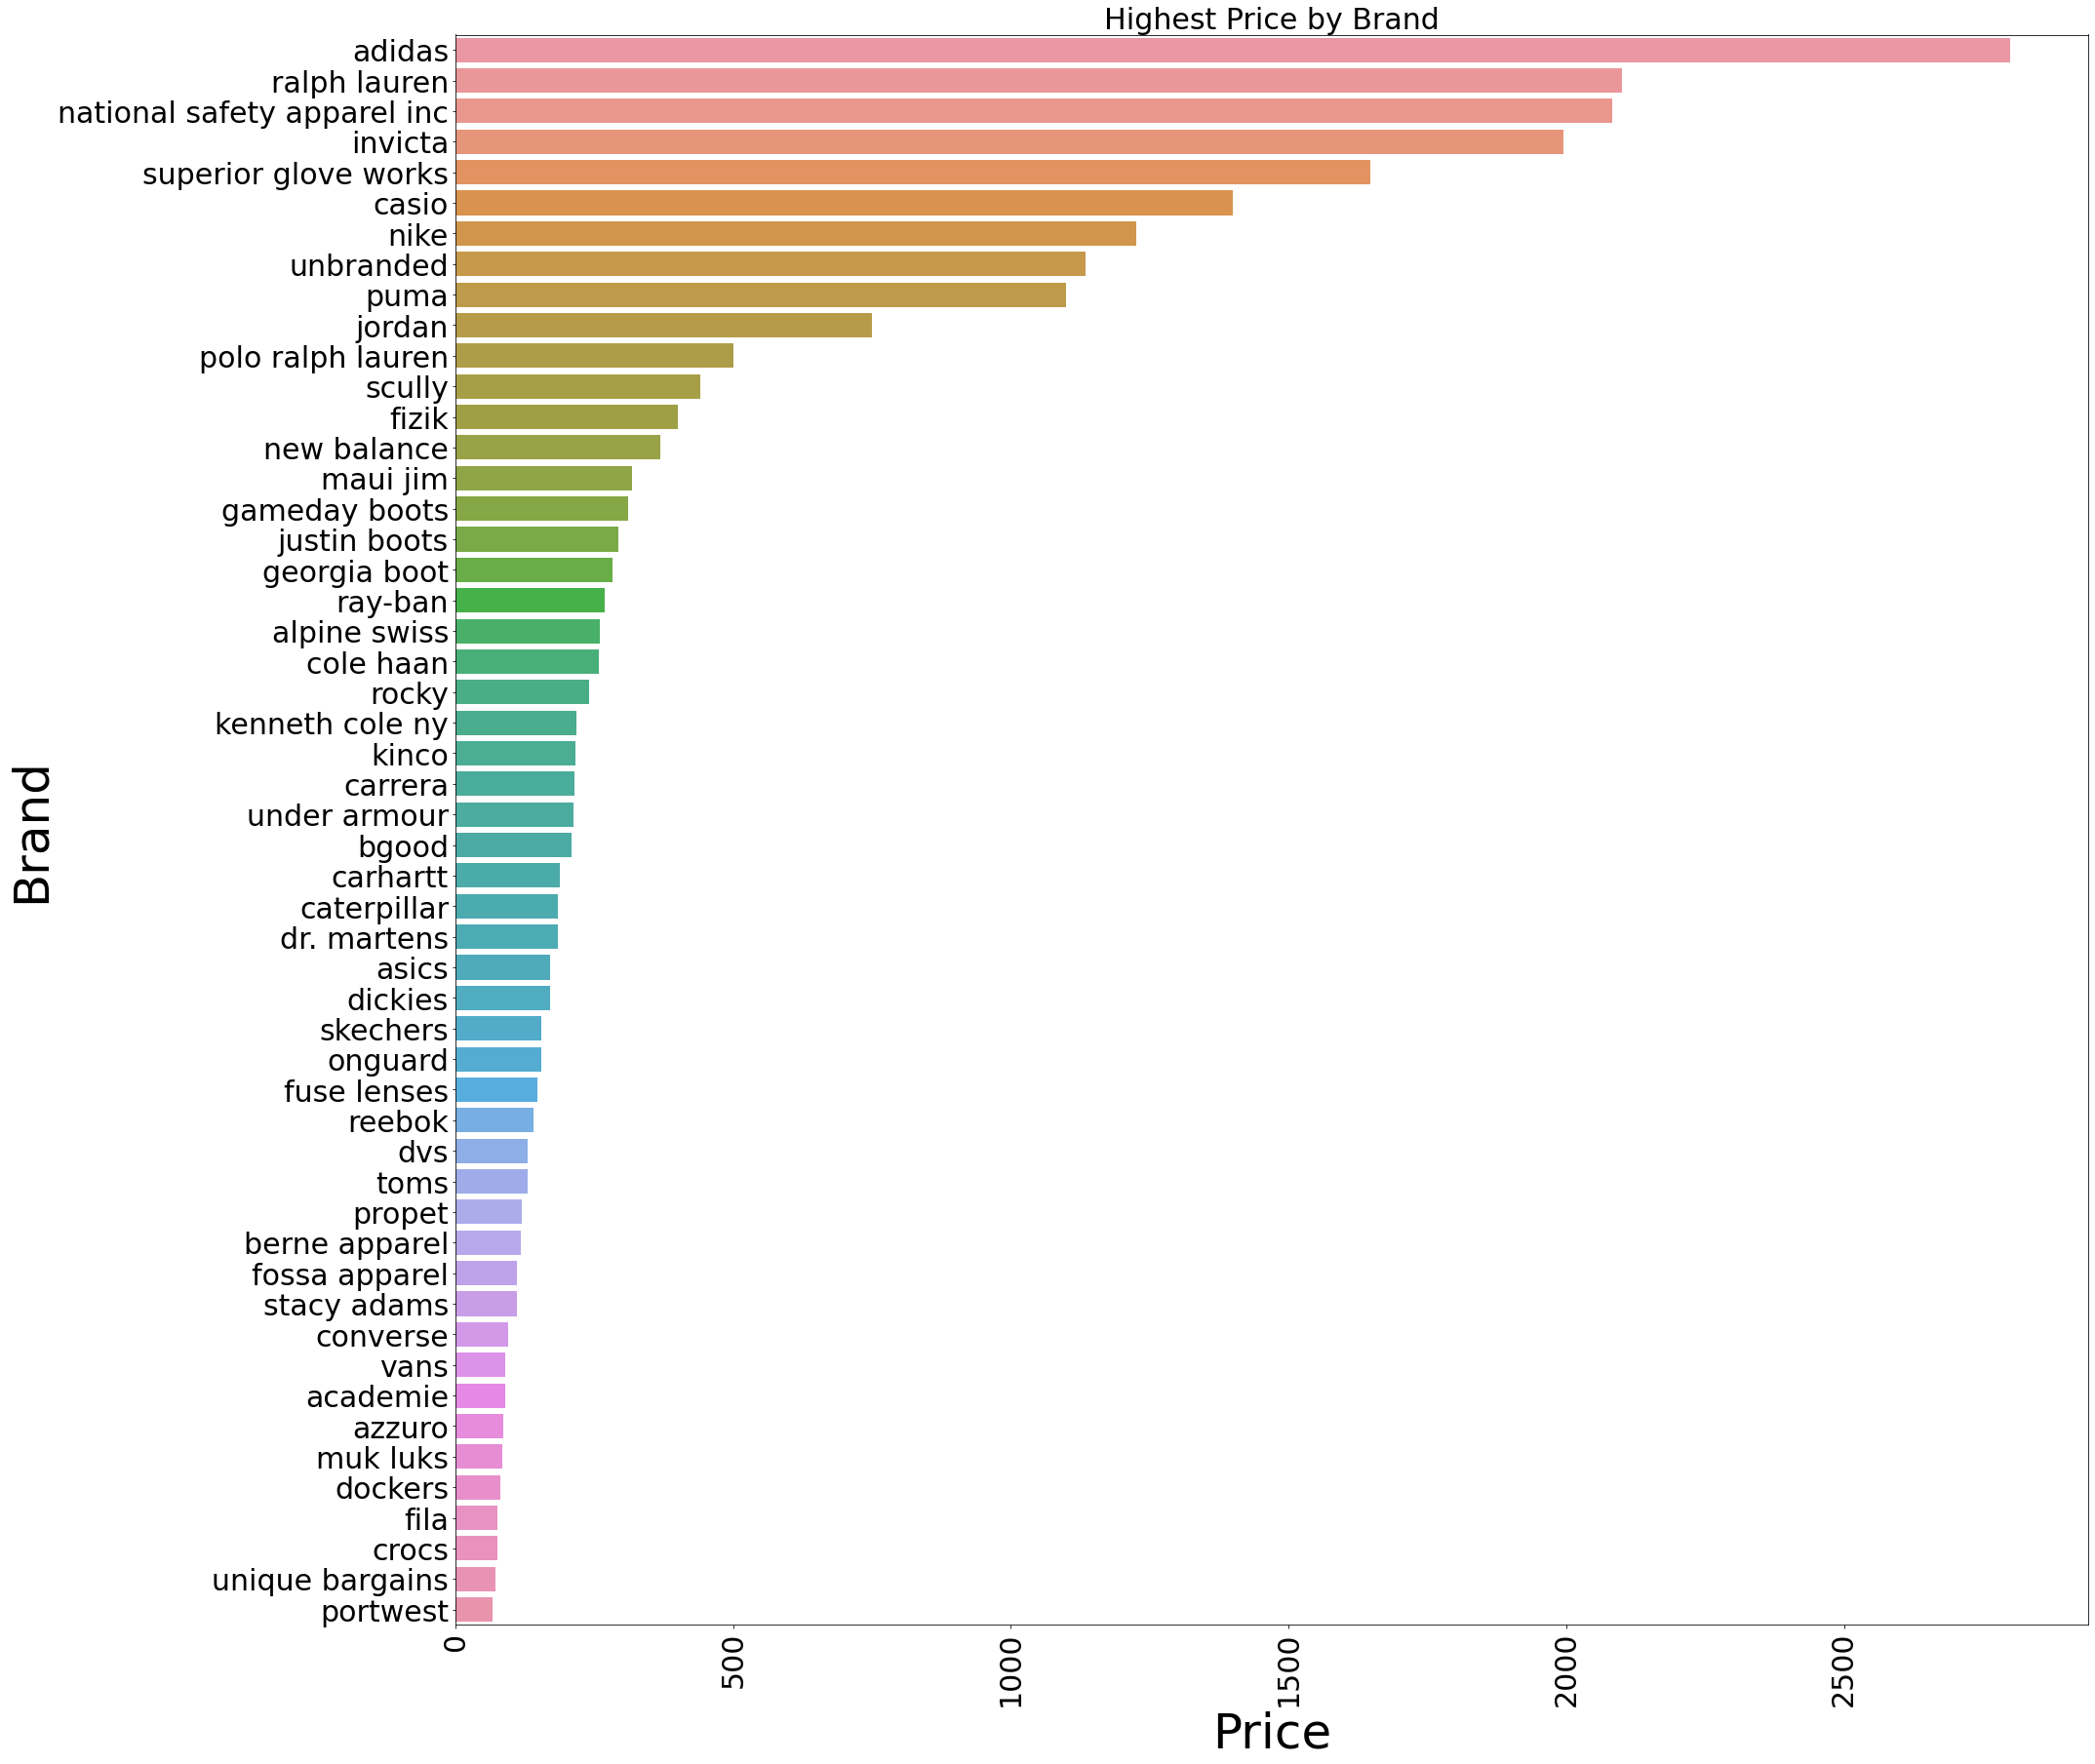

In [29]:
fig = plt.figure(figsize=(30, 30))
sns.barplot(data=df_max_prices,x="price",y="brand")
plt.xticks(fontsize=30, rotation=90)
plt.yticks(fontsize=30)
plt.title('Highest Price by Brand',fontsize=30)
plt.xlabel('Price',fontsize=50)
plt.ylabel('Brand',fontsize=50)

## Which ones have the widest distribution of prices?


In [30]:
df_medians = df_cleaned[df_cleaned.brand.isin(brands_above_50.index)]
df_medians = df_medians.groupby('brand').median()
df_medians = df_medians.sort_values('price', ascending=False)
df_medians.head()

,price
brand,
ralph lauren,425.000000
casio,383.579987
fizik,290.622498
gameday boots,259.989990
invicta,204.990005


The answer to this question is up for debate depending on the interpretation of the question. "Widest distribution" could be defined in a number of ways including:

- Standard deviation (nominal or as a percentage)
- The interquratile range (IQR)
- Difference between maximum and minimum values
Most of this information can be captured by utilizing boxplots. The boxplots could be ordered in a number of ways, but using the median tends to yield a fairly orderly result.

In [31]:
df_cleaned[df_cleaned.brand.isin(brands_above_50.index)].groupby("brand").price.std().sort_values(ascending=False).head(10)

brand
invicta                        466.782736
ralph lauren                   454.266605
national safety apparel inc    268.146549
adidas                         240.998708
casio                          237.883196
superior glove works           137.995958
scully                         103.428460
unbranded                       98.552838
jordan                          79.747950
nike                            77.459707
Name: price, dtype: float64

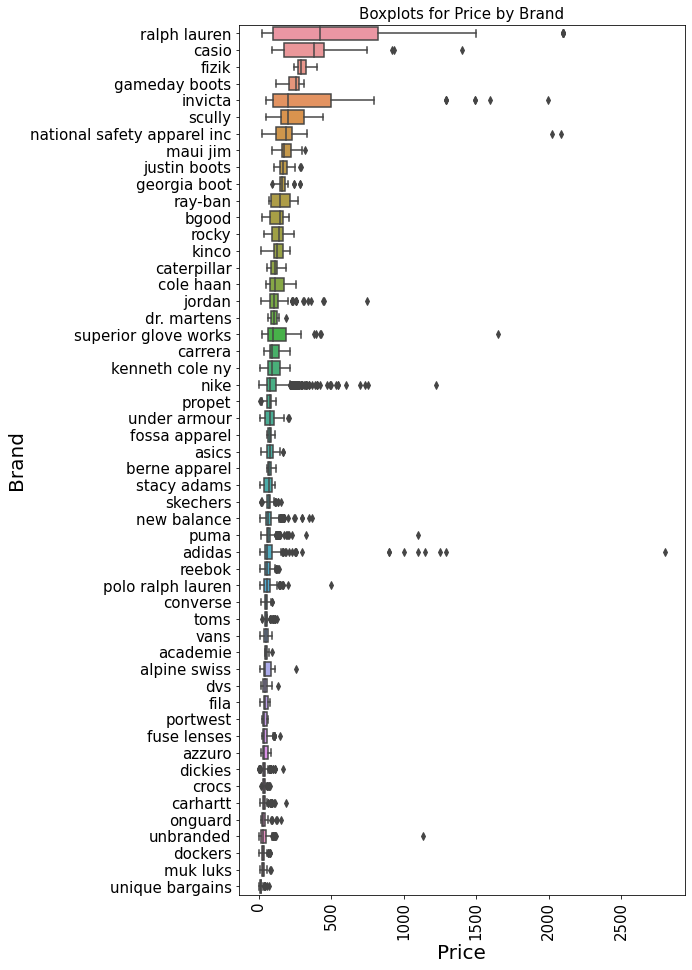

In [32]:
fig = plt.figure(figsize=(8, 16))
sns.boxplot(data= df_cleaned[df_cleaned.brand.isin(brands_above_50.index)] , x = "price" , y = "brand",order=df_medians.index)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.title('Boxplots for Price by Brand',fontsize=15)
plt.xlabel('Price',fontsize=20)
plt.ylabel('Brand',fontsize=20)
plt.show()

### Is there a typical price distribution (e.g., normal) across brands or within specific brands?


Text(0.5, 0, 'Price')

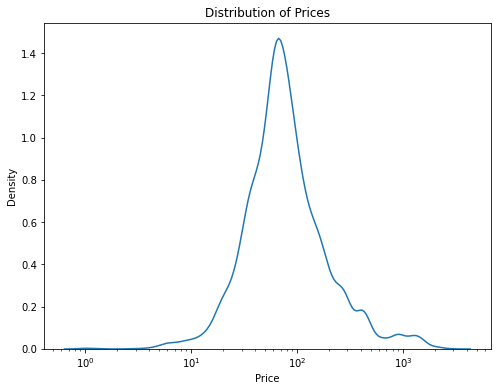

In [33]:
df_all_dist = df_cleaned[df_cleaned.brand.isin(brands_above_50.index)]
fig = plt.figure(figsize=(8, 6))
sns.kdeplot(df_all_dist['price'],log_scale=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')

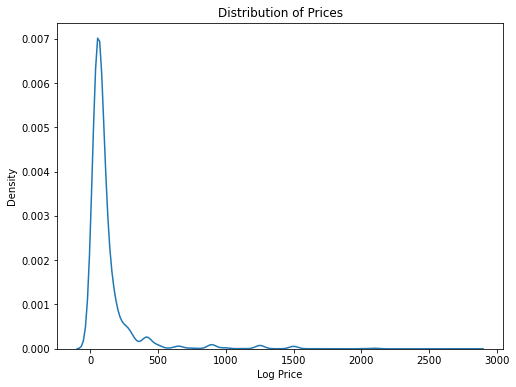

In [34]:
fig = plt.figure(figsize=(8, 6))
sns.kdeplot(df_all_dist['price'])
plt.title('Distribution of Prices')
plt.xlabel('Log Price')
plt.show()

In [35]:
type(df_all_dist)

pandas.core.frame.DataFrame

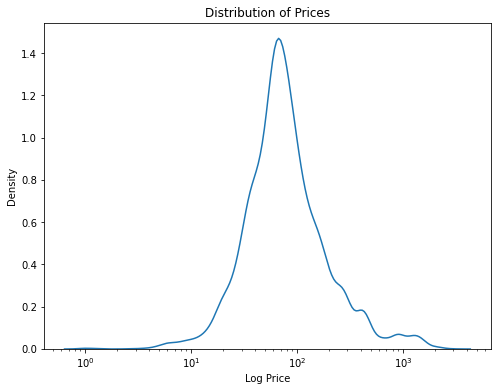

In [36]:
fig = plt.figure(figsize=(8, 6))
sns.kdeplot(df_all_dist['price'], log_scale=True)
plt.title('Distribution of Prices')
plt.xlabel('Log Price');

In [37]:
sns.__version__

'0.11.1'